### Libraries

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from pyDOE import lhs
from torch import tensor
import torch.nn as nn
import scipy.io
from scipy.integrate import odeint, solve_ivp

### Parameters

In [2]:
torch.set_default_dtype(torch.double)
layer_sizes = [1, 40, 40, 40, 3]
activation = nn.Tanh()
num_epochs = 40000
lr = 1e-3
test_freq = 50
num_domain = 500  # number of training collocation data points inside the domain
num_data = 100    # number od data from numerical solution
gpu = 0
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Lorenz system

$$ 
\frac{dx1}{dt} = 10 * (x2 - x1)  \\
\frac{dx2}{dt} = x1 * (15 - x3) - x2 \\
\frac{dx3}{dt} = x1 * x2 - 8/3 * x3
$$

$$ 
\frac{dx1}{dt} = \lambda_1 * (x2 - x1)  \\
\frac{dx2}{dt} = x1 * (\lambda_2 - x3) - x2 \\
\frac{dx3}{dt} = x1 * x2 - \lambda_3 * x3
$$

### Initial Condition:

$$
x1(0) = -8 \\
x2(0) = 7  \\
x3(0) = 27
$$


# Data + Visualization

In [3]:
def lorenzNoNoise(t, s):
    
    # assign each ODE to a vector element
    x = s[0]
    y = s[1]
    z = s[2]

    # define each ODE
    dx = -10*x + 10* y
    dy = 15*x - 1*x*z - y
    dz = x*y - 8/3*z

    return [dx, dy, dz]


x0 = [-8., 7, 27]  # Initial state of the system

t_span = (0.0, 3)
ts = np.arange(0.0, 3, 0.001)

Samples = solve_ivp(lorenzNoNoise, t_span, x0, t_eval=ts)  # solving the sys. ODEs to get the true data

In [4]:
# reshaping the data for feeding to the model
data_input_all = torch.from_numpy(ts).view(-1,1)
data_output_all = torch.permute(torch.from_numpy(Samples.y), (1, 0))

ub = data_input_all.max()
lb = data_input_all.min()

# selecting the desired number of data points from the whole data
t_data = data_input_all[::(int(data_input_all.shape[0]/num_data))]
x_data = data_output_all[::(int(data_input_all.shape[0]/num_data))]

t_col = lb + (ub-lb) * lhs(t_data.shape[1], num_domain)
t_col = torch.vstack((t_col, t_data))

In [32]:
x_data.shape

torch.Size([100, 3])

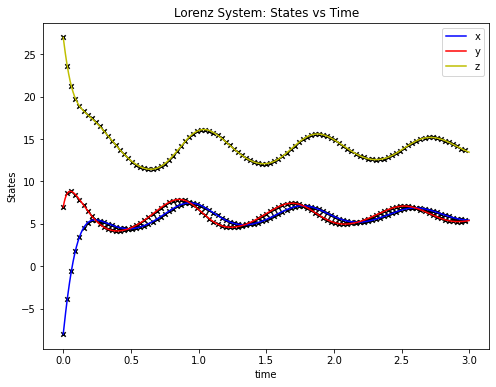

In [38]:
# plotting the true data
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(data_input_all,data_output_all[:,0],'b-',label='x',)
plt.plot(data_input_all,data_output_all[:,1],'r-',label='y')
plt.plot(data_input_all,data_output_all[:,2],'y-',label='z')
plt.scatter(t_data, x_data[:,0], color='black', marker='x', s=20)
plt.scatter(t_data, x_data[:,1], color='black', marker='x', s=20)
plt.scatter(t_data, x_data[:,2], color='black', marker='x', s=20)
plt.xlabel('time')
plt.ylabel('States')
plt.title('Lorenz System: States vs Time')
plt.legend()
plt.show()

# Preparing Data

In [6]:
print(f"{t_data.shape[0]} initial points for initial and boundary loss.")
print(f"{t_col.shape[0]} collocation points inside the domain including boundaries for PDE loss.")

100 initial points for initial and boundary loss.
600 collocation points inside the domain including boundaries for PDE loss.


In [7]:
class PhysicsInformedNet(nn.Module):
    
    def __init__(self, layer_sizes, activation=nn.Tanh()):
        super(PhysicsInformedNet, self).__init__()
        
        # defining parameters of the PDE to be identified with their corresponding initial values
        self.lambda_1 = nn.Parameter(torch.tensor([1.]))
        self.lambda_2 = nn.Parameter(torch.tensor([1.]))
        self.lambda_3 = nn.Parameter(torch.tensor([1.]))
        
        self.layers = []
        
        for i in range(1, len(layer_sizes)-1):     # defining the neural network
            self.layers.extend([nn.Linear(layer_sizes[i-1], layer_sizes[i]), activation])
            
        self.layers.extend([nn.Linear(layer_sizes[-2], layer_sizes[-1])])
        
        self.net = nn.Sequential(*self.layers)

        # Initialize weights using Xavier initialization and biases to zero
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.net(x)

In [8]:
# Define the physics-based model
def PDE(t_col):
    
    t = t_col.clone()
    t.requires_grad = True
    x = model(t)
    x1, x2, x3 = x[:, 0:1], x[:, 1:2], x[:, 2:3]
    x1_t = torch.autograd.grad(x1, t, grad_outputs = torch.ones(x1.shape), create_graph=True)[0] # [0] element inside the tuple
    x2_t = torch.autograd.grad(x2, t, grad_outputs = torch.ones(x2.shape), create_graph=True)[0]
    x3_t = torch.autograd.grad(x3, t, grad_outputs = torch.ones(x3.shape), create_graph=True)[0]

    f1 = x1_t + model.lambda_1*x1 - 10* x2
    f2 = x2_t - model.lambda_2*x1 + 1*x1*x3 + x2
    f3 = x3_t - x1*x2 + model.lambda_3*x3
    
    return f1, f2, f3


# Define the loss function
def loss_func(t_col, t_data, x_data, model):
    
    x_pred = model(t_data)
    x1_pred = x_pred[:, 0:1]
    x2_pred = x_pred[:, 1:2]
    x3_pred = x_pred[:, 2:3]
    
    x1_data = x_data[:, 0:1]
    x2_data = x_data[:, 1:2]
    x3_data = x_data[:, 2:3]
    
    loss_data1 = F.mse_loss(x1_pred, x1_data)
    loss_data2 = F.mse_loss(x2_pred, x2_data)
    loss_data3 = F.mse_loss(x3_pred, x3_data)
    
    
    f_pred1, f_pred2, f_pred3 = PDE(t_col)
    
    loss_PDE1 = torch.mean(f_pred1**2)
    loss_PDE2 = torch.mean(f_pred2**2)
    loss_PDE3 = torch.mean(f_pred3**2)
    
    loss = loss_PDE1 + loss_PDE2 + loss_PDE3 + loss_data1 + loss_data2 + loss_data3
    
    return loss

In [9]:
# creating the model object and the optimizer

model = PhysicsInformedNet(layer_sizes, activation)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [10]:
%%time
Loss_his = []
# Training the PINN
for i in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_func(t_col, t_data, x_data, model)
    loss.backward()
    optimizer.step()
    Loss_his.append(loss.detach().cpu().numpy())
    if i%(num_epochs/10)==0:
        print(f"Loss: {loss.detach().cpu().numpy()}, Parameters: [{model.lambda_1.item()}, {model.lambda_2.item()}, {model.lambda_3.item()}]")

Loss: 265.90137922782685, Parameters: [1.0009999999963188, 1.0009999999801265, 0.9990000000058985]
Loss: 76.69581545242823, Parameters: [1.9720179680437246, 1.3023775517294356, 0.07567235052660534]
Loss: 71.4054354854775, Parameters: [6.772419652422338, 4.728979704930881, 0.07832021690449781]
Loss: 31.59779878496004, Parameters: [9.758155764974, 10.610863557023189, 1.5022353141993519]
Loss: 1.298508171995693, Parameters: [9.251241200610263, 13.834821467473859, 2.839520811756856]
Loss: 0.018255957363352077, Parameters: [9.945232799162355, 14.984229341027755, 2.66291874848089]
Loss: 0.006773798224783169, Parameters: [10.011549244521673, 15.00345103906397, 2.666748184825839]
Loss: 0.009151288046339209, Parameters: [10.010317495560434, 15.00399257148481, 2.6670708966762047]
Loss: 0.0043096858604162, Parameters: [10.008443328884274, 15.003973389288506, 2.6672087450507234]
Loss: 0.003262956695172521, Parameters: [10.00728993626223, 15.003963891564908, 2.6673643334654247]
CPU times: user 16mi

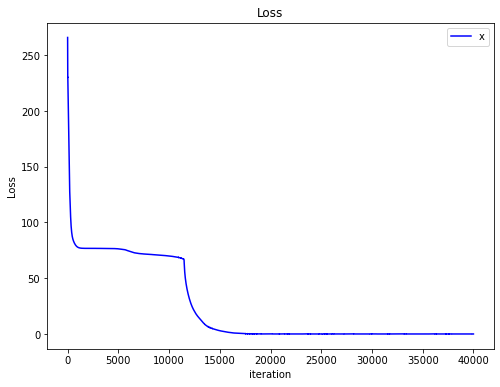

In [11]:
# plotting the Loss over iteration
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(np.array(Loss_his),'b-',label='x',)
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

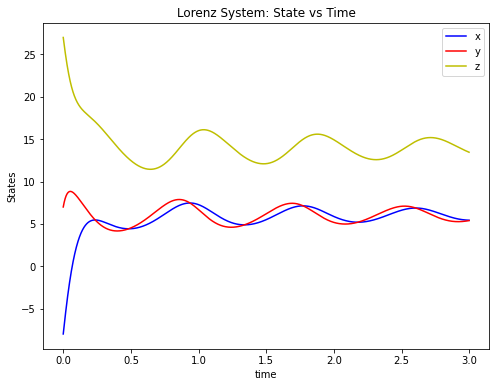

In [12]:
# plotting the predicted states over time
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(data_input_all,model(data_input_all).detach().cpu().numpy()[:,0],'b-',label='x',)
plt.plot(data_input_all,model(data_input_all).detach().cpu().numpy()[:,1],'r-',label='y')
plt.plot(data_input_all,model(data_input_all).detach().cpu().numpy()[:,2],'y-',label='z')
plt.xlabel('time')
plt.ylabel('States')
plt.title('Lorenz System: State vs Time')
plt.legend()
plt.show()

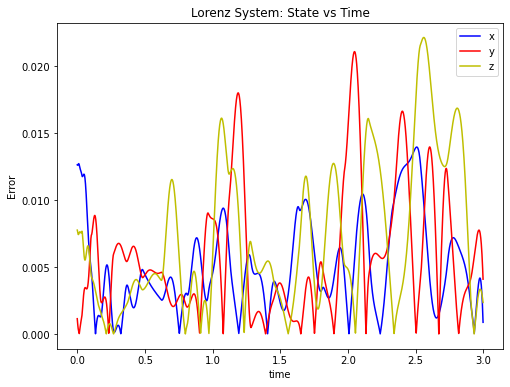

In [13]:
# Plotting errors
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(data_input_all,np.abs(data_output_all-(model(data_input_all).detach().cpu().numpy()))[:,0],'b-',label='x',)
plt.plot(data_input_all,np.abs(data_output_all-(model(data_input_all).detach().cpu().numpy()))[:,1],'r-',label='y')
plt.plot(data_input_all,np.abs(data_output_all-(model(data_input_all).detach().cpu().numpy()))[:,2],'y-',label='z')
plt.xlabel('time')
plt.ylabel('Error')
plt.title('Lorenz System: State vs Time')
plt.legend()
plt.show()

# 1% Noise

In [26]:
noise = 0.01        
x_data_noise = x_data + torch.tensor(noise*np.std(np.array(x_data),axis=0)*np.random.randn(x_data.shape[0], x_data.shape[1]))

In [27]:
# creating the model object and the optimizer

model = PhysicsInformedNet(layer_sizes, activation)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [28]:
%%time
Loss_his2 = []
# Training the PINN
for i in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_func(t_col, t_data, x_data, model)
    loss.backward()
    optimizer.step()
    Loss_his2.append(loss.detach().cpu().numpy())
    if i%(num_epochs/10)==0:
        print(f"Loss: {loss.detach().cpu().numpy()}, Parameters: [{model.lambda_1.item()}, {model.lambda_2.item()}, {model.lambda_3.item()}]")

Loss: 313.98054679065456, Parameters: [1.0009999999418278, 1.000999999624313, 0.9990000000237764]
Loss: 76.71864858720542, Parameters: [1.941478478918336, 1.301763913418512, 0.075402237780894]
Loss: 71.7287358811187, Parameters: [6.533625061194181, 4.327600213081058, 0.07503068649876495]
Loss: 43.473662100928735, Parameters: [10.382439610644285, 10.07941666043856, 1.0581601986274265]
Loss: 2.1395997437878203, Parameters: [9.24942286766108, 13.664802632512703, 2.8891330041832983]
Loss: 0.09092336368094509, Parameters: [10.03122374830457, 14.975877185536906, 2.6542899742888553]
Loss: 0.04457652128445032, Parameters: [10.069525353373573, 15.004719463932236, 2.6575050595953877]
Loss: 0.07493719266393213, Parameters: [10.042536546252402, 15.004797341079325, 2.661043751514303]
Loss: 0.012650371398148213, Parameters: [10.026827953844538, 15.004579026771978, 2.6633803503747644]
Loss: 0.0076144049648065905, Parameters: [10.018066655247733, 15.00457538332843, 2.6648501077265108]
CPU times: user 